Epoch 1/30, Loss: 2.3026
Epoch 2/30, Loss: 2.3026
Epoch 3/30, Loss: 2.3026
Epoch 4/30, Loss: 2.3026
Epoch 5/30, Loss: 2.3026
Epoch 6/30, Loss: 2.3026
Epoch 7/30, Loss: 2.3026
Epoch 8/30, Loss: 2.3026
Epoch 9/30, Loss: 2.3026
Epoch 10/30, Loss: 2.3026
Epoch 11/30, Loss: 2.3026
Epoch 12/30, Loss: 2.3026
Epoch 13/30, Loss: 2.3026
Epoch 14/30, Loss: 2.3026
Epoch 15/30, Loss: 2.3026
Epoch 16/30, Loss: 2.3026
Epoch 17/30, Loss: 2.3026
Epoch 18/30, Loss: 2.3026
Epoch 19/30, Loss: 2.3026
Epoch 20/30, Loss: 2.3026
Epoch 21/30, Loss: 2.3026
Epoch 22/30, Loss: 2.3026
Epoch 23/30, Loss: 2.3026
Epoch 24/30, Loss: 2.3026
Epoch 25/30, Loss: 2.3026
Epoch 26/30, Loss: 2.3026
Epoch 27/30, Loss: 2.3026
Epoch 28/30, Loss: 2.3026
Epoch 29/30, Loss: 2.3026
Epoch 30/30, Loss: 2.3026
Class 0: TP=0, TN=8743, FP=277, FN=980
       Precision=0.0000, Recall=0.0000, F1=0.0000, Accuracy=0.0000
Class 1: TP=9, TN=8828, FP=37, FN=1126
       Precision=0.1957, Recall=0.0079, F1=0.0152, Accuracy=0.0009
Class 2: TP=76, T

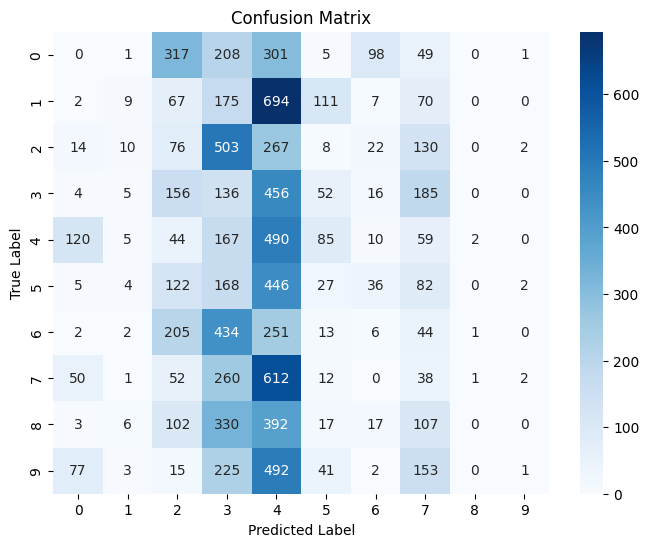

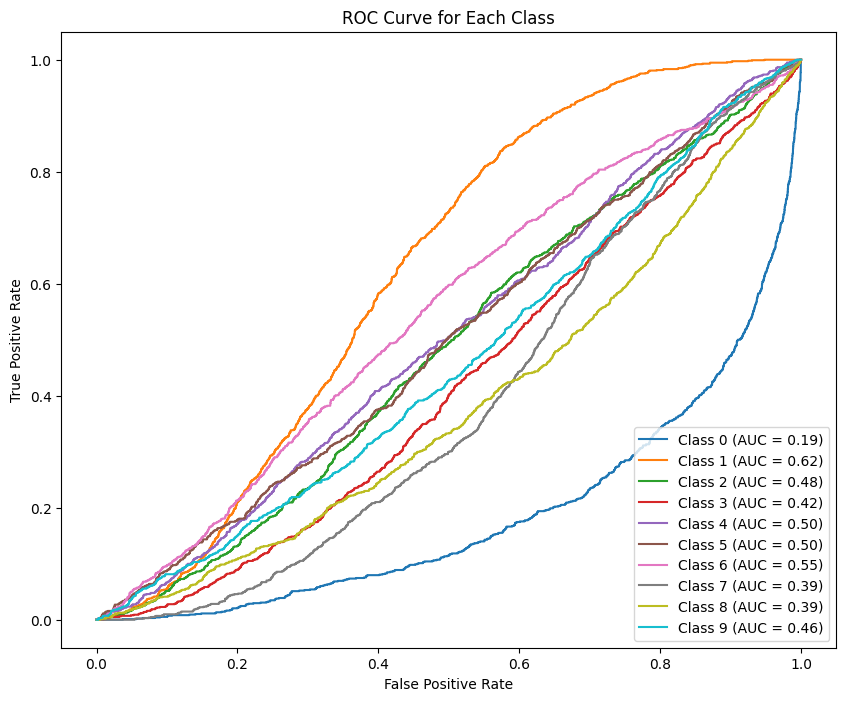

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import struct
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

def load_mnist_images(filename):
    with open(filename, 'rb') as f:
        _, num, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows * cols)
        return images / 255.0

def load_mnist_labels(filename):
    with open(filename, 'rb') as f:
        _, num = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

# 加载 MNIST 数据集
X_train = load_mnist_images("/content/train-images.idx3-ubyte__")[:60000]
y_train = load_mnist_labels("/content/train-labels.idx1-ubyte__")[:60000]
X_test = load_mnist_images("/content/t10k-images.idx3-ubyte__")[:20000]
y_test = load_mnist_labels("/content/t10k-labels.idx1-ubyte__")[:20000]

# 激活函数
def relu(x): return np.maximum(0, x)
def tanh(x): return np.tanh(x)
def softplus(x): return np.log1p(np.exp(x))
def leaky_relu(x, alpha=0.1): return np.where(x > 0, x, alpha * x)
def softmax(x): return np.exp(x - np.max(x, axis=1, keepdims=True)) / np.sum(np.exp(x - np.max(x, axis=1, keepdims=True)), axis=1, keepdims=True)

def one_hot(y, num_classes=10):
    encoder = OneHotEncoder(sparse_output=False, categories=[range(num_classes)])
    return encoder.fit_transform(y.reshape(-1, 1))
def cross_entropy(y_pred, y_true):
    return -np.mean(np.sum(y_true * np.log(y_pred + 1e-9), axis=1))

def forward_pass(X, weights, activations):
    a = X
    for W, activation in zip(weights, activations):
        z = np.dot(a, W)
        a = activation(z)
    return a

# 初始化权重
np.random.seed(42)
input_size = 784
hidden1 = 128
hidden2 = 64
output_size = 10

best_loss = float('inf')
best_weights = None


W1 = np.random.randn(input_size, hidden1) * 0.01
W2 = np.random.randn(hidden1, hidden2) * 0.01
W3 = np.random.randn(hidden2, output_size) * 0.01
weights = [W1, W2, W3]
activations = [relu, relu, softmax]

y_train_oh = one_hot(y_train)
y_test_oh = one_hot(y_test)

# 训练参数
epochs = 30
learning_rate = 0.01

for epoch in range(epochs):
    # 前向传播
    hidden1_output = relu(np.dot(X_train, W1))
    hidden2_output = relu(np.dot(hidden1_output, W2))
    y_pred = softmax(np.dot(hidden2_output, W3))

    # 计算损失
    loss = cross_entropy(y_pred, y_train_oh)
    if loss < best_loss:
      best_loss = loss
      best_weights = [W1, W2, W3]  # 保存当前 epoch 的权重

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")

hidden1_output_test = relu(np.dot(X_test, W1))
hidden2_output_test = relu(np.dot(hidden1_output_test, W2))
y_pred_test = softmax(np.dot(hidden2_output_test, W3))
y_pred_labels = np.argmax(y_pred_test, axis=1)

# 计算混淆矩阵
def compute_confusion_matrix(y_true, y_pred, num_classes=10):
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))
    total_tp = 0  # 计算所有 TP 之和
    total_samples = np.sum(cm)  # 总样本数

    for i in range(num_classes):
        TP = cm[i, i]
        FN = np.sum(cm[i, :]) - TP
        FP = np.sum(cm[:, i]) - TP
        TN = total_samples - (TP + FN + FP)

        # 计算 Precision, Recall, F1 和 Accuracy
        precision = TP / (TP + FP) if TP + FP != 0 else 0
        recall = TP / (TP + FN) if TP + FN != 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if precision + recall != 0 else 0
        accuracy_class = TP / (TP + FN + FP + TN)  # 每个类别的 Accuracy

        total_tp += TP  # 累加所有 TP

        # 输出每个类别的 TP, TN, FP, FN 以及 Precision, Recall, F1, Accuracy
        print(f"Class {i}: TP={TP}, TN={TN}, FP={FP}, FN={FN}")
        print(f"       Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}, Accuracy={accuracy_class:.4f}")

    # 计算整体准确率
    overall_accuracy = total_tp / total_samples
    print(f"\nOverall Accuracy: {overall_accuracy:.4f}")
    return cm

cm = compute_confusion_matrix(y_test, y_pred_labels, num_classes=10)

# 绘制混淆矩阵
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 计算 ROC 曲线
def compute_roc(y_true_oh, y_pred_proba):
    plt.figure(figsize=(10, 8))

    # 计算每个类别的 FPR 和 TPR，计算 ROC 曲线及 AUC 值
    for i in range(10):
        fpr, tpr, thresholds = roc_curve(y_true_oh[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)



        # 绘制每个类别的 ROC 曲线
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')


    # 设置图表标签和标题
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Each Class")

    # 显示图例
    plt.legend(loc='lower right')

    # 显示图形
    plt.show()

compute_roc(y_test_oh, y_pred_test)